<a href="https://colab.research.google.com/github/KenyanGeek/World-Class-Species-Classifier/blob/master/Code_for_Rapid_Prototyping_of_AI_based_Species_Classifiers_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is a guide to prototyping world class species classifiers for non-experts and is a step by step guide that is an appendix of the *Guide for Non-Experts: Rapid Prototyping of World Class AI based Species Classifiers using Deep Learning* by Chege et.al., If you do not have experience with using Google Colab and Jupyter Notebooks please consider this short tutorial: 
https://www.youtube.com/watch?v=inN8seMm7UI. Also please feel free to fork this notebook so that you can use it in your own environment!

# SETUP AND ACCESSING YOUR DATA

In [0]:
#CODE BLOCK 1#
#Here we import the fast.ai library and specifically the vision function as this is an image 
#classification problem
from fastai import *
from fastai.vision import *


In [2]:
#CODE BLOCK 2#
#Here we use this code to access  google drive where we uploaded our data - note you'll have to have uploaded
#data in the form proposed in the paper on google drive to be able to access it using this method
#We will need to input a code on the dialog that appears below after we run the code block

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA PREPARATION

In [0]:
#CODE BLOCK 3#
#Here we save the connected data folder path as a variable 

path = '/content/drive/My Drive/AI side projects/seastar classification/data'


In [0]:
#CODE BLOCK 4#
#Here we use the ImageDataBunch function to divide our data into training, validation (20%) and test sets 
#We also carry out transformations of th images by limiting them to 224 pixels to save space and normalize 
#to imagenet stats, the later are important steps but which you need not worry about now

np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)


In [5]:
#CODE BLOCK 5#
#Here we view how the above Imagedatabunch function has distributeed our data into training, 
#validation and test data

data

ImageDataBunch;

Train: LabelList (229 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pisaster ochreaus,pisaster ochreaus,pisaster ochreaus,pisaster ochreaus,pisaster ochreaus
Path: /content/drive/My Drive/AI side projects/seastar classification/data;

Valid: LabelList (57 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pisaster ochreaus,solaster dawsoni,pycnopodia helianthoides,pycnopodia helianthoides,solaster dawsoni
Path: /content/drive/My Drive/AI side projects/seastar classification/data;

Test: None

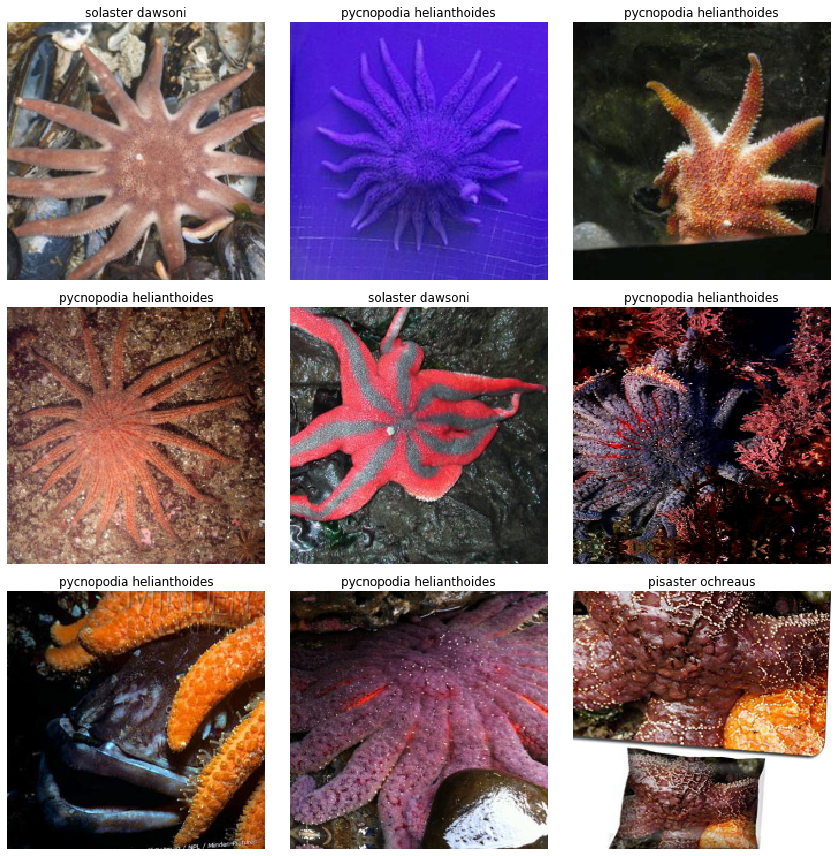

In [6]:

#CODE BLOCK 6#
# Here we can view the data and confirm if it is the correct data before feeding it into the learner to create a model

data.show_batch(rows=3, figsize=(12,12))



In [7]:
#CODE BLOCK 7#
# Here we evaluate the statistics of the classes, the categories we are trying to understand,
# the number in the training, validation and test sets

data.classes, data.c, len(data.train_ds), len(data.valid_ds)


(['pisaster ochreaus', 'pycnopodia helianthoides', 'solaster dawsoni'],
 3,
 229,
 57)

# MODEL TRAINING

In [0]:
#CODE BLOCK 8#
# Here we setup the cnn_learner using the data, download the pretrained model and error metric we are 
# interested in and save it to a variable learn

learn = cnn_learner(data, models.resnet34, metrics=accuracy)


In [9]:
#CODE BLOCK 9#
# This is the most crucial stage where we train our model for 4 epochs

learn.fit_one_cycle(10)


In [0]:
#CODE BLOCK 10#
# Here we save the model in our directory on google drive under models/stage_1.pth

learn.save('stage-1')


# MODEL TUNING


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


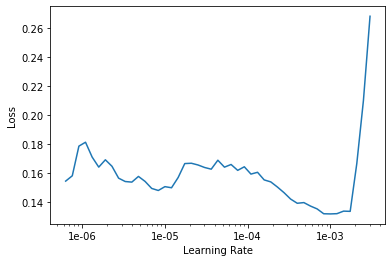

In [11]:
#CODE BLOCK 11#
# At this point the model is good enough, however if you want more superior accuracy for instance
# to illustrate superiority in benchmark problems you can tune the model using the tricks below


learn.unfreeze()
#here you unfreeze the model
learn.lr_find()
#here you find the learning rate and create a plot - you can use that plot to understand where the decline was sharpest
#and use those values in the next tuning phase 
learn.recorder.plot()
# If the plot is not showing try to give a start and end learning rate - the default below will also work fine
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)

In [12]:
#CODE BLOCK 12#
# By studying the above graphical output from the previous code we can now tune the model by capturing the 
# range with the sharpest decline in our case 1e-04,1e-03
learn.fit_one_cycle(10, max_lr=slice(1e-05,1e-04))


In [0]:

#CODE BLOCK 13#
# Here we save the tuned model in our directory on google drive as stage_2.pth
learn.save('stage-2')


In [0]:
#CODE BLOCK 14#
# Here we can now load it ready for inference 

learn.load('stage-2');


In [15]:
#CODE BLOCK 15#
# Here we can use the build in function and our model to create a new variable interp  

interp = ClassificationInterpretation.from_learner(learn,ds_type=DatasetType.Train)


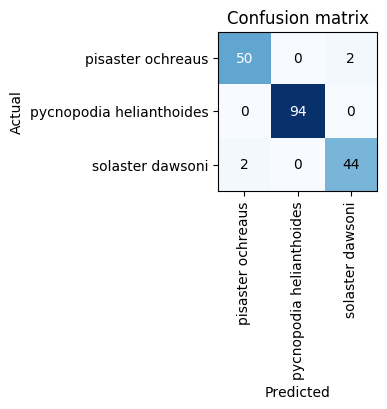

In [16]:
#CODE BLOCK 16#
# We can use interp to see which of our images are being misclassified - this can help tune the model further 
# for more accuracy

interp.plot_confusion_matrix(dpi=100)


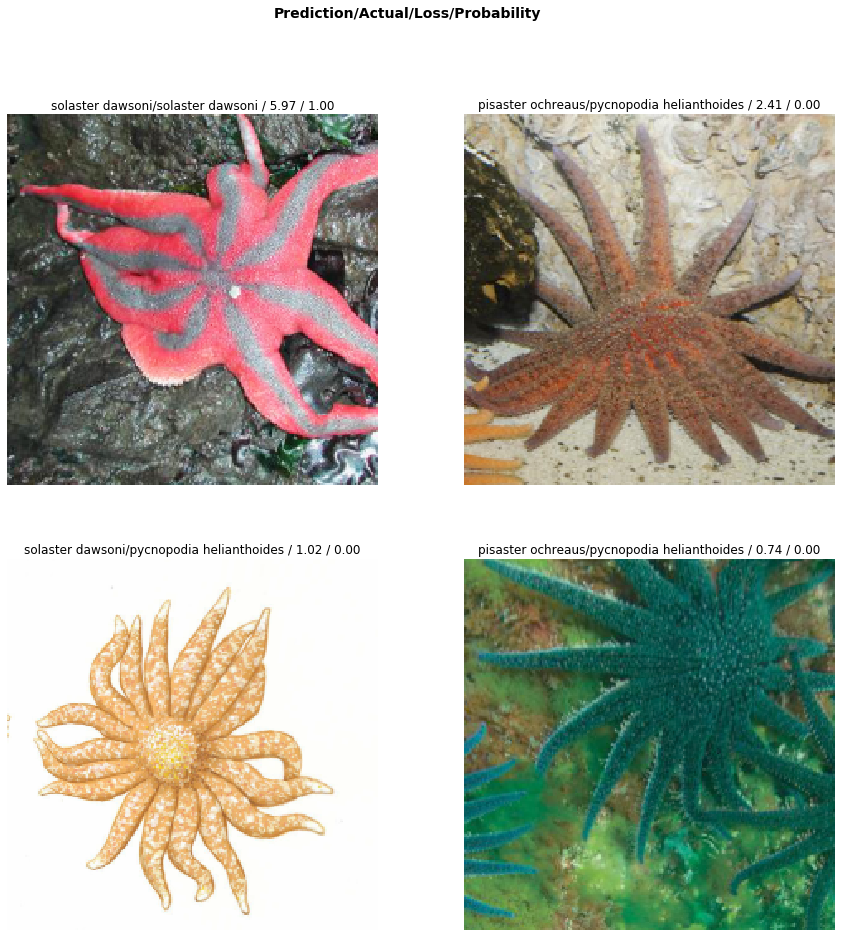

In [17]:

#CODE BLOCK 17#
# We can even plot the images that are doing the poorest and even target them for removal

interp.plot_top_losses(4, figsize=(15,15))



# DEPLOYMENT PREPARATIONS

In [0]:
#CODE BLOCK 18#
# if we have experimented enough above and are satisfied with our results and model accuracy we can now export the 
#model for deployment

learn.export()


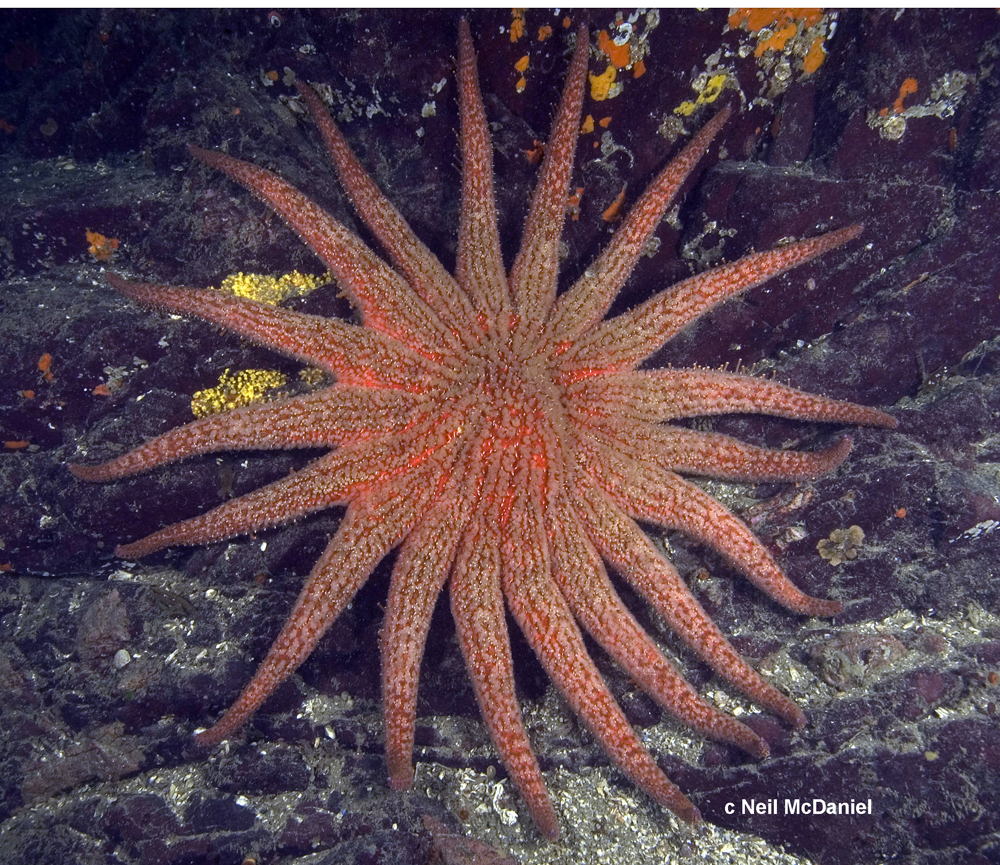

In [24]:
#CODE BLOCK 19#
# Before we deploy it live we can do some testing
# The first line of code changes the environment to cpu - remember CPU IS GOOD and CHEAP FOR inference
# Then we can refer to a directory with a test picture that the model has never seen
# And then you can view it so that you can judge if the model is right or wrong

defaults.device = torch.device('cpu')
img = open_image('/content/drive/My Drive/AI side projects/test/Pycnopodia helianthoides (81) R.jpg')
img


In [25]:
#CODE BLOCK 20#
# Then you can load the model from our path
# And now you can predict and see if your model works!


learn = load_learner(path)
pred_class,pred_idx,outputs = learn.predict(img)
pred_class


Category pycnopodia helianthoides

PERFECT PREDICTION ON THE PYCNOPODIA!

NOW ITS TIME TO DEPLOY AND SHARE YOUR AI SPECIES CLASSIFIER WITH THE WORLD!